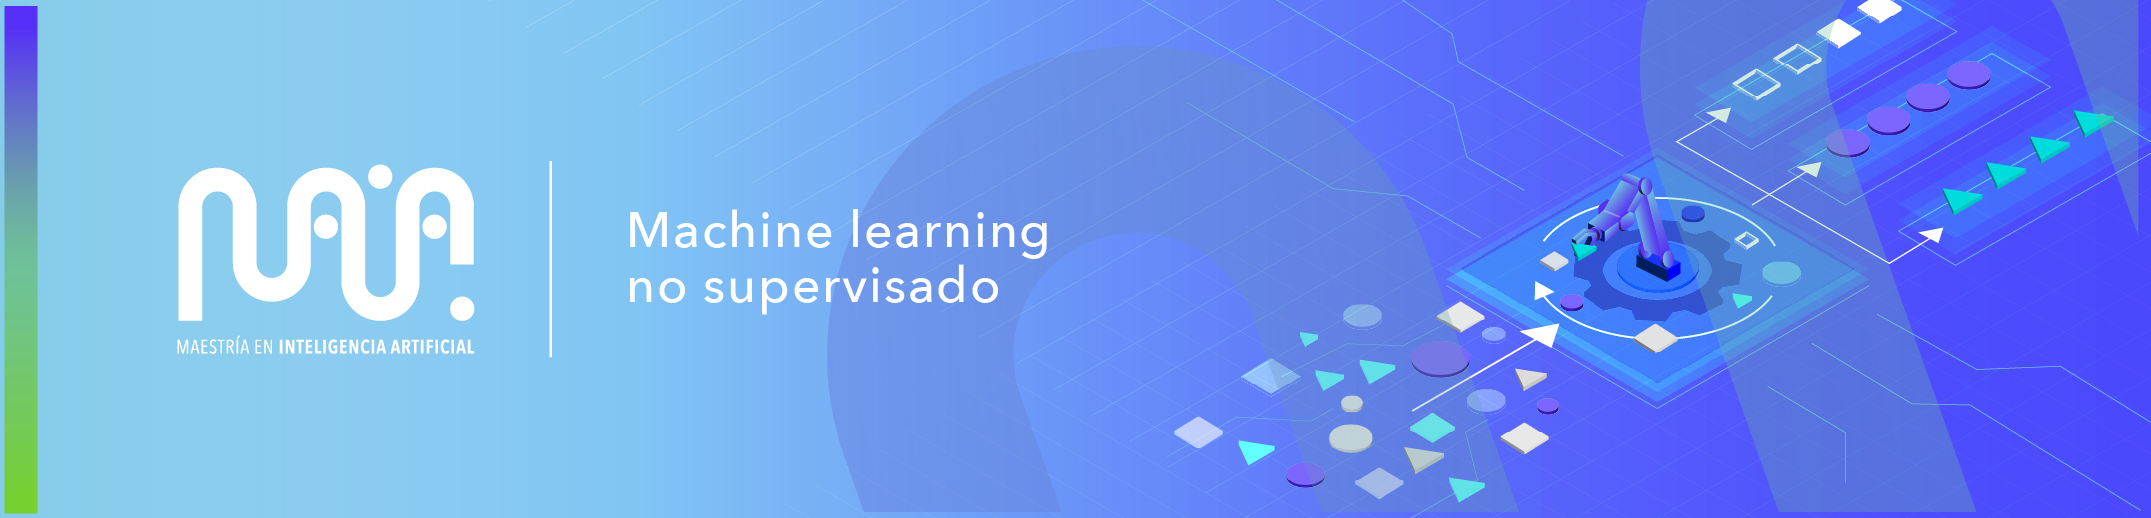

# Solución de problemas con DBSCAN - caso 1

En este tutorial aprenderás cómo crear un modelo de agrupación por densidad haciendo uso del algoritmo DBSCAN. En ese sentido, realizarás una selección de dos hiperparámetros: épsilon y el mínimo de puntos en la vecindad de un punto núcleo. Adicionalmente, utilizarás el coeficiente de la silueta para validar la selección y realizarás la interpretación de los grupos resultantes del mejor modelo mediante diagramas de caja. En este sentido, veremos cómo realizar los siguientes procesos:

1. [Importar las librerías necesarias.](#1.-Importación-de-librerías-requeridas)
2. [Cargar un conjunto de datos procesado.](#2.-Carga-de-datos)
3. [Seleccionar los hiperparámetros `eps` y `min_samples`.](#3.-Selección-de-los-hiperparámetros-eps-y-min_samples)
4. [Interpretar los grupos resultantes del mejor modelo.](#4.-Interpretación-de-los-grupos-resultantes-del-mejor-modelo)

---

<font size="3">**Contexto**  
<font size="2"> El conjunto de datos que utilizaremos se relaciona con la caracterización de vinos con base en atributos como el pH, la cantidad de dióxido de azufre, azúcar residual, entre otros. Este conocimiento puede resultar muy útil en la certificación de la calidad de una muestra de vino a partir de variables fisicoquímicas. Los datos han sido descargados a partir de este [enlace](https://www.kaggle.com/datasets/rajyellow46/wine-quality) y modificados para propósitos de este ejercicio. Es un caso ideal que permitirá ejemplificar todo el proceso.  
Cita: Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `numpy`, `joblib` y `scikit-learn`, así como las librerías de visualización `matplotlib` y `seaborn`. Usaremos las siguientes clases y funciones para entrenar y evaluar el modelo de DBSCAN:

* [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html): función para obtener el valor promedio del coeficiente de la silueta.
* [`silhouette_samples()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html): función para obtener el coeficiente de la silueta para cada ejemplo.
* [`DBSCAN()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html): clase para crear el modelo de DBSCAN.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN

## 2. Carga de datos

Realizaremos la carga de datos ya procesados usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data = pd.read_csv('data/wine_quality_processed.csv', sep=',')

Además, realizaremos la carga del mismo objeto utilizado en el procesamiento, de la clase `StandardScaler()`:

In [3]:
standard_scaler = joblib.load('obj/scaler')

/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Veamos los primeros datos del conjunto utilizando `head()`:

In [4]:
data.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.014686         -0.598414     0.687864        0.647556  -0.490277   
1       0.116950         -0.429483     0.489375        0.679115  -0.788505   
2      -0.136908          0.224380     1.273631        0.890364  -1.134886   
3       1.140204          0.623189    -1.306935       -0.696380   1.018252   
4       0.086776         -0.860876     0.688661        0.950283  -0.847040   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -0.481295             -1.087387 -0.860845  1.023142  -1.216361   
1            -0.483734             -1.094311 -1.029712  1.386693  -0.791893   
2            -0.175259              0.759525  1.811517 -0.956226  -0.342054   
3             1.564610              0.786791 -0.411051 -0.632910   1.301869   
4            -0.608213             -1.104763 -0.805384  1.672159  -1.114566   

    alcohol  
0 -0.204441  
1 -0.234492  
2  0.377655  
3 -0.044845  
4 -0.189747

Al igual que con KMeans y KMedoides, DBSCAN utiliza métricas de distancia, aunque este último utiliza la distancia para conectar puntos por densidad. Al tener solo variables numéricas, no tendremos que preocuparnos por tratar con variables binarias, pero igualmente tendremos que estandarizar.

## 3. Selección de los hiperparámetros `eps` y `min_samples`

Como ya has visto, DBSCAN tiene dos hiperparámetros que deben ser definidos antes del entrenamiento: épsilon y el mínimo de puntos en la vecindad. Estos hiperparámetros están representados por los parámetros `eps` y `min_samples` de la clase `DBSCAN()`. Pero ¿cómo podemos seleccionar el mejor valor para cada uno? Una de las formas más sencillas es mediante un Grid-Search o búsqueda exhaustiva, en la que probaremos todas las combinaciones de valores, entrenando un modelo por cada una:

In [5]:
# Definimos el espacio de búsqueda con dos listas:
# Valores de Épsilon
eps_list = [0.5, 1, 1.5, 2, 2.5, 3]
# Valores del mínimo de puntos
min_samples_list = [3, 5, 7, 10]

Es importante resaltar que los valores de épsilon no pueden ser arbitrarios. Al tratarse de un hiperparámetro que define el radio de búsqueda alrededor de un punto, sus valores están muy relacionados con la métrica de distancia que vayamos a utilizar. En ese sentido, el espacio de búsqueda está definido teniendo en cuenta que vamos a utilizar la distancia euclidiana.

Al terminar el entrenamiento de los modelos, necesitamos una forma de compararlos para saber cuál es "el mejor". En ese sentido, reutilizaremos el método de la silueta, calculando qué tan bien definidos están los clústeres resultantes y obteniendo un valor comparable entre modelos.

### Método de la silueta

Como habías visto en el tutorial anterior, el método de la silueta es un tipo de análisis que mide la distancia entre clústeres y la distancia al clúster más cercano para cada dato, retornando un valor entre -1 y 1. Valores cercanos a 1 indican que un dato está lejos de los demás clústeres, mientras que valores cercanos a -1 indican que un dato está más cerca a otro clúster que al que fue asignado.

Definiremos la función `silhouette_scores_DBSCAN()`, que calcula el coeficiente promedio para cada posible combinación de `(eps, min_samples)` en nuestro espacio de búsqueda. Ten en cuenta que el parámetro `metric` corresponde al parámetro del mismo nombre de la clase `DBSCAN()`, por lo que los valores válidos son los que se definen en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html):

In [6]:
def silhouette_scores_DBSCAN(X, eps_list, min_samples_list, metric):
    """
    Calcula el coeficiente de la silueta para todas las combinaciones de (eps, min_samples) usando DBSCAN
    
    Parametros:
    X : np.array
        El arreglo con los datos
    eps_list : list
        Lista de valores para el hiperparámetro épsilon
    min_samples_list : list
        Lista de valores para el hiperparámetro min_samples
    metric : str
        Métrica de distancia a utilizar
    """
    # Vamos a almacenar cada combinación, el coeficiente de la silueta y el número de clústeres
    scores, eps_scores, min_samples_scores, num_clusters = [], [], [], []
    # Definimos la búsqueda exhaustiva con dos ciclos
    # El primero recorre todos los valores de épsilon
    for i in range(len(eps_list)):
        # Y el segundo recorre todos los valores de min_samples
        for j in range(len(min_samples_list)):
            # Obtenemos los valores actuales para los hiperparámetros
            eps_i = eps_list[i]
            min_samples_j = min_samples_list[j]
            eps_scores.append(eps_i)
            min_samples_scores.append(min_samples_j)
            # Definimos un modelo de DBSCAN con los valores actuales
            model_ij = DBSCAN(eps=eps_i, min_samples=min_samples_j, metric=metric, n_jobs=-1)
            # Entrenamos el modelo
            model_ij.fit(X)
            labels_ij = model_ij.labels_
            num_clusters_ij = len(set(labels_ij))
            num_clusters.append(num_clusters_ij)
            # Almacenamos el coeficiente de la silueta
            # Si tenemos un número de clústeres mayor a 1, el coeficiente de la silueta está definido
            if num_clusters_ij > 1:
                score = silhouette_score(X, labels_ij)
                scores.append(score)
            # Si DBSCAN retorna un solo clúster, el coeficiente de la silueta no está definido
            else:
                scores.append(-1)
    # Construimos un DataFrame para retornar el resultado
    scores_df = pd.DataFrame({
        'epsilon': eps_scores,
        'min_samples': min_samples_scores,
        'score': scores,
        'num_clusters': num_clusters
    })
    # Retornamos el DataFrame ordenado por el coeficiente promedio
    return scores_df.sort_values('score', ascending=False)

Al definir la función para realizar la búsqueda exhaustiva, podemos visualizar el comportamiento para nuestro conjunto de datos (**Nota:** la ejecución de la celda puede tardarse un poco):

In [7]:
silhouette_scores = silhouette_scores_DBSCAN(data, eps_list, min_samples_list, 'euclidean')
silhouette_scores

epsilon  min_samples     score  num_clusters
12      2.0            3  0.681632             4
19      2.5           10  0.681632             4
17      2.5            5  0.681632             4
16      2.5            3  0.681632             4
15      2.0           10  0.681632             4
14      2.0            7  0.681632             4
13      2.0            5  0.681632             4
11      1.5           10  0.681632             4
10      1.5            7  0.681632             4
9       1.5            5  0.681632             4
8       1.5            3  0.681632             4
18      2.5            7  0.681632             4
7       1.0           10  0.679754             5
6       1.0            7  0.677265             5
5       1.0            5  0.677265             5
4       1.0            3  0.677265             5
20      3.0            3  0.602398             3
21      3.0            5  0.602398             3
22      3.0            7  0.602398             3
23      3.0           10  0.602398             3
2       0.5            7 -0.370931            11
1       0.5            5 -0.408080            16
0       0.5            3 -0.461586            70
3       0.5           10 -0.467721            10

Como puedes observar, DBSCAN retorna un valor máximo para el coeficiente de la silueta de 0.681632, definiendo 4 clústeres. Si revisamos el valor de `eps`, podemos observar que el rango de valores óptimo se encuentra en [1.5, 2.5], mientras que `min_samples` puede tomar cualquier valor dentro del espacio de búsqueda que definimos inicialmente.

Para obtener una descripción más detallada del coeficiente de la silueta para cada escenario, modificaremos la función `silhouette_analysis()`:

In [9]:
def silhouette_analysis(X, silhouette_scores, metric):
    """
    Genera gráficas con el coeficiente de la silueta para cada clúster y cada ejemplo
    
    Parametros:
    X : np.array
        El arreglo con los datos
    silhouette_scores : pd.DataFrame
        El DataFrame retornado por la función silhouette_scores_DBSCAN()
    metric : str
        Métrica de distancia a utilizar
    """
    for i in range(len(silhouette_scores)):
        eps_i, min_samples_i, score_i, clusters_i = silhouette_scores.iloc[i]
        # Definimos el modelo
        clusterer = DBSCAN(eps=eps_i, min_samples=int(min_samples_i), metric=metric, n_jobs=-1)
        # Entrenamos el modelo
        cluster_labels = clusterer.fit_predict(X)
        # Obtenemos el coeficiente para cada ejemplo
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        # Inicializamos una figura
        fig = plt.figure(figsize = (18, 7))
        plt.xlim([-0.2, 1])
        plt.ylim([0, len(X) + (int(clusters_i) + 1) * 10])

        y_lower = 10
        for j in set(cluster_labels):
            # Obtenemos los valores del coeficiente para cada clúster
            jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
            # Ordenamos los valores de mayor a menor
            jth_cluster_silhouette_values.sort()
            size_cluster_j = jth_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j

            color = cm.nipy_spectral(float(j) / int(clusters_i))
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                jth_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower = y_upper + 10

        plt.title(f"Método de la silueta (eps={eps_i}, min_samples={min_samples_i}, k={int(clusters_i)})")
        plt.xlabel("Coeficiente")
        plt.ylabel("Clúster")

        # Incluimos el valor promedio
        plt.axvline(x=score_i, color="red", linestyle="--")
        plt.yticks([])
        plt.xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

Con la función modificada, realizaremos el análisis específico para las primeras cinco filas de `silhouette_scores`:

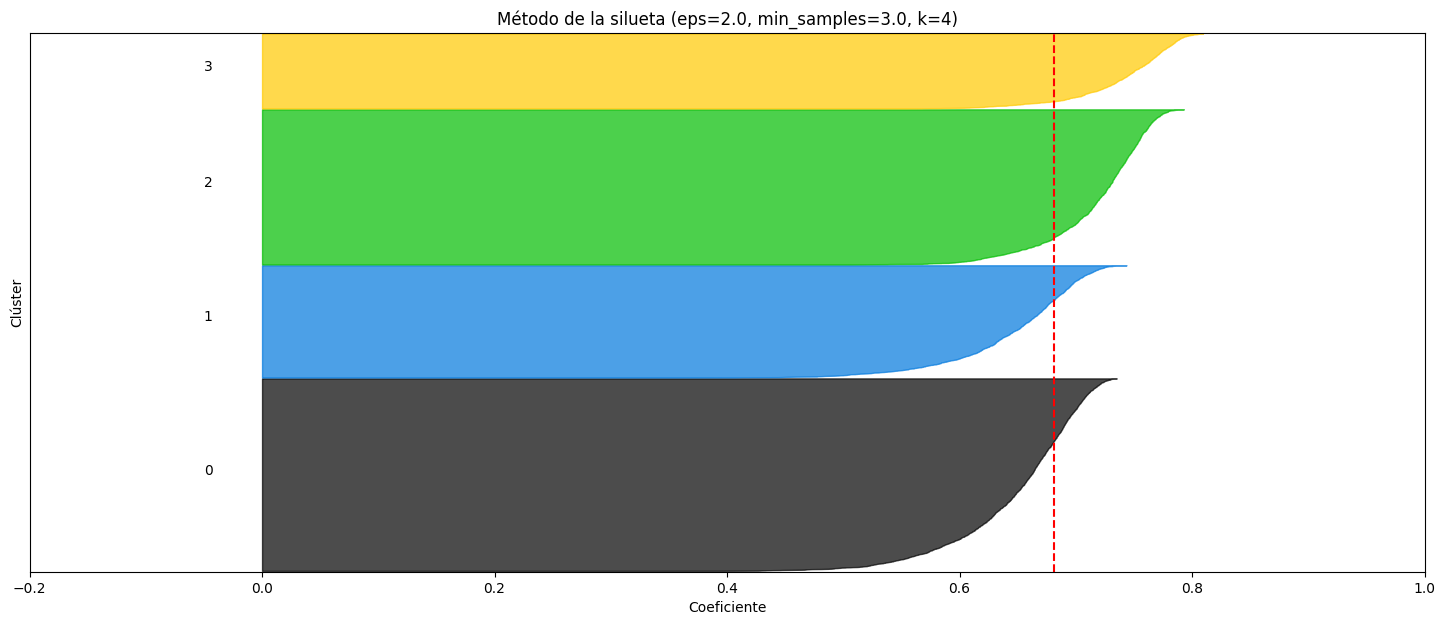

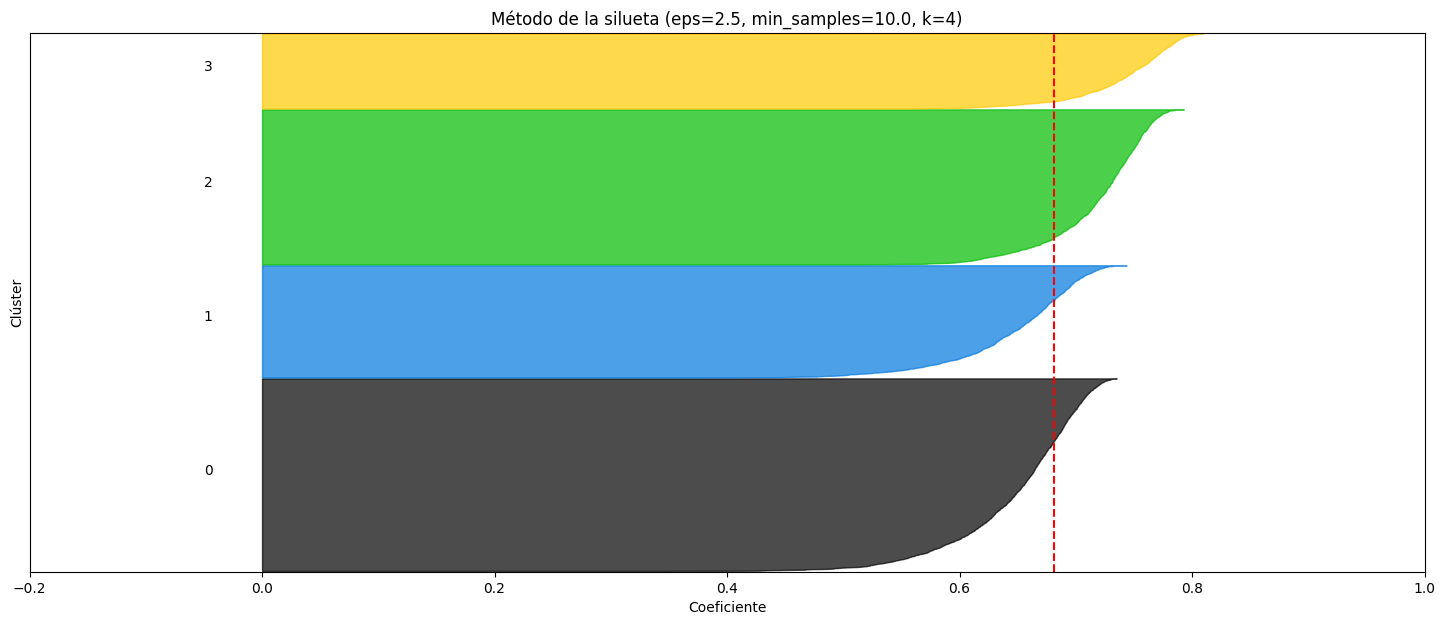

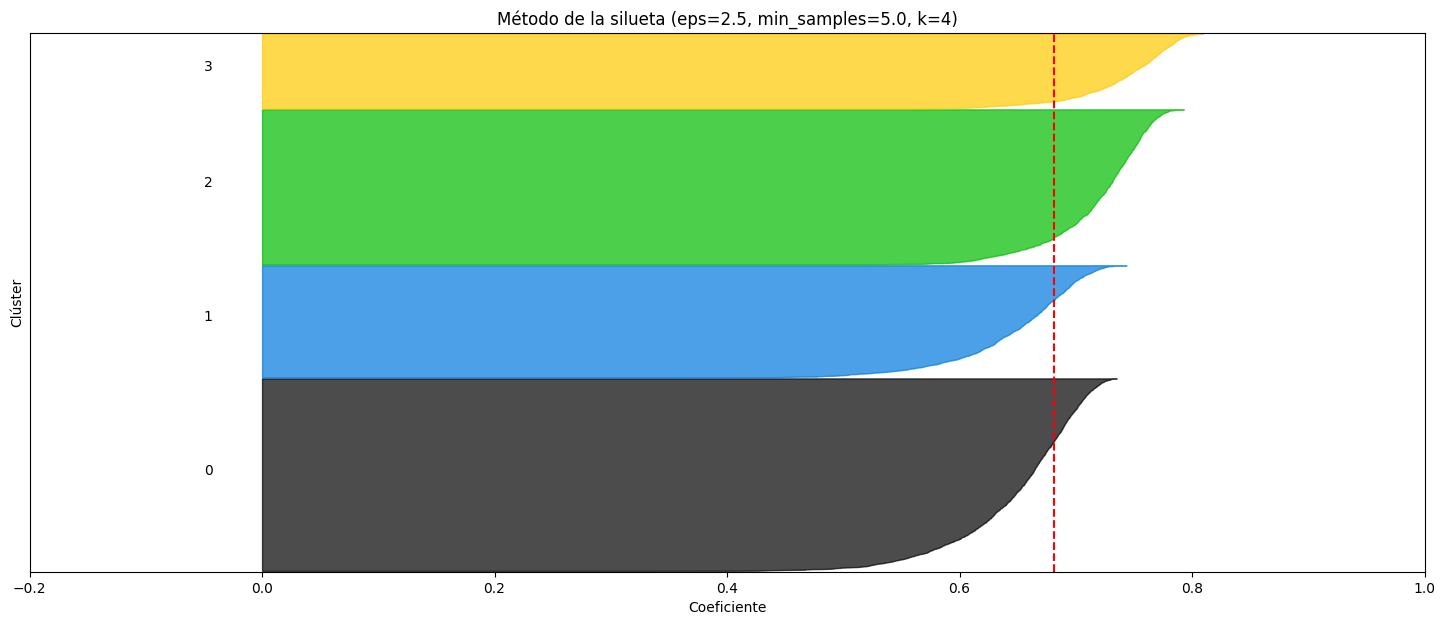

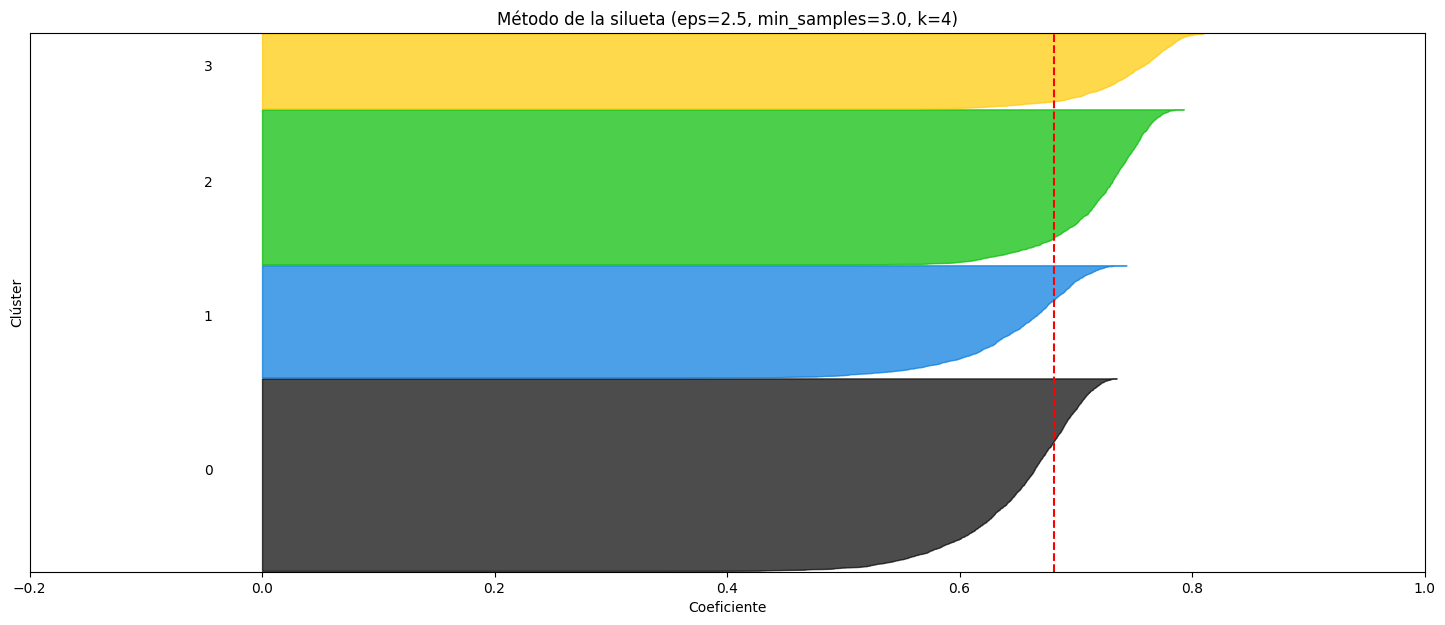

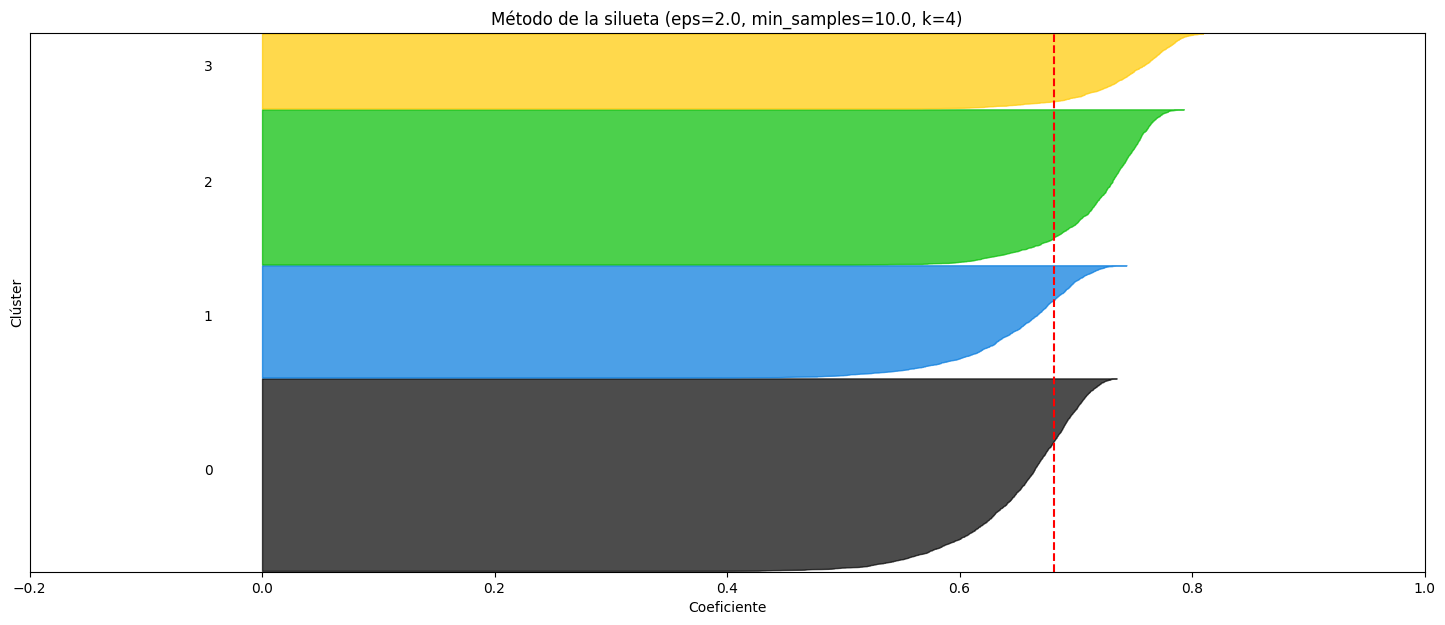

In [10]:
silhouette_analysis(data, silhouette_scores[:5], 'euclidean')

Como puedes observar, los tamaños de los clústeres y el comportamiento de cada ejemplo asignado a ellos es prácticamente idéntico para los cinco primeros casos. En general, los coeficientes son positivos para todos los datos y tienen un valor por encima de 0.5. Además, no tenemos puntos atípicos (identificados como el clúster con índice -1).

Puedes modificar el rango de `silhouette_scores` que le damos a la función `silhouette_analysis()`. Por ejemplo ¿qué sucede en los últimos cinco resultados?

## 4. Interpretación de los grupos resultantes del mejor modelo

Realizando la búsqueda exhaustiva de hiperparámetros, es posible concluir que los valores óptimos de `eps` se encuentran en el rango [1.5-2.5] y que `min_samples` puede tomar cualquier valor en el rango [3-10]. Adicionalmente, DBSCAN nos dice que el número óptimo de clústeres para este conjunto de datos es 4. Finalmente, entrenaremos el mejor modelo utilizando la primera fila de `silhouette_scores`:

In [11]:
mejor_eps, mejor_min_samples, _, _= silhouette_scores.iloc[0]
mejor_modelo = DBSCAN(eps=mejor_eps, min_samples=int(mejor_min_samples), metric='euclidean', n_jobs=-1)
mejor_modelo.fit(data)

DBSCAN(eps=2.0, min_samples=3, n_jobs=-1)

Veremos cuántos datos hay en cada grupo mediante el atributo `labels_` y la función `unique()` de `numpy`:

In [12]:
labels = mejor_modelo.labels_
indexes, values = np.unique(labels, return_counts=True)

{indexes[i]: values[i] for i in range(len(indexes))}

{0: 2339, 1: 1364, 2: 1884, 3: 910}

También podemos usar `plt.bar()` para graficar estos valores:

([<matplotlib.axis.XTick at 0x30f696fa0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

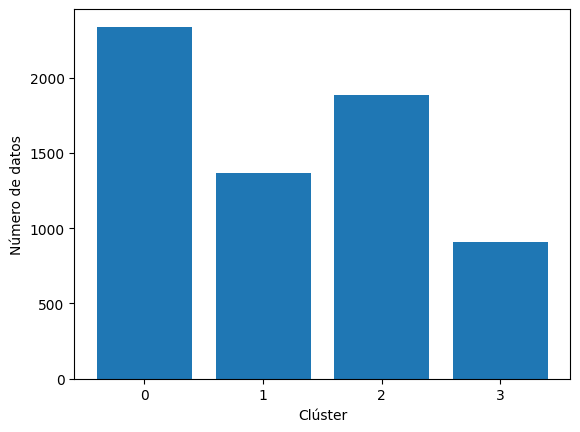

In [13]:
rects = plt.bar(indexes, values)
plt.xlabel('Clúster')
plt.ylabel('Número de datos')
plt.xticks(indexes)

### Análisis de datos por clúster

Utilizaremos el objeto `standard_scaler` para realizar una transformación inversa mediante el método `inverse_transform()`, permitiéndonos realizar un análisis con mayor facilidad:

In [14]:
# inverse_transform(data) retorna un arreglo de Numpy
data_original = standard_scaler.inverse_transform(data)
# Utilizaremos las columnas de la variable data para construir un DataFrame
data_original = pd.DataFrame(data_original, columns=data.columns)
# Si añadimos una columna con el resultado de la agrupación, 
# podremos interpretar el resultado fácilmente
data_original['Cluster'] = mejor_modelo.labels_
data_original

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0          7.234557          0.243457     0.419709        7.962324   0.038618   
1          7.369499          0.271877     0.390503        8.104328   0.027626   
2          7.034522          0.381878     0.505901        9.054899   0.014858   
3          8.719731          0.448970     0.126187        1.914938   0.094222   
4          7.329684          0.199302     0.419826        9.324518   0.025468   
...             ...               ...          ...             ...        ...   
6492       6.610882          0.118255     0.514772        9.330868   0.016143   
6493       8.307069          0.332705     0.112397        0.964245   0.080577   
6494       9.065209          0.389874     0.138444        0.868217   0.091786   
6495       7.302277          0.212740     0.390930        8.808020   0.033818   
6496       4.302904          0.345221     0.267901       -3.334260   0.123077   

      free_sulfur_dioxide  total_sulfur_dioxide   density        pH  \
0               21.467972             52.379252  0.991983  3.388739   
1               21.424550             51.986231  0.991482  3.447039   
2               26.916458            157.226408  0.999907  3.071319   
3               57.891995            158.774276  0.993316  3.123167   
4               19.208419             51.392843  0.992147  3.492818   
...                   ...                   ...       ...       ...   
6492            17.439798            168.206837  0.999330  3.154179   
6493            60.523416            173.137343  0.993340  3.073356   
6494            51.003105            175.254590  0.992207  3.045076   
6495            25.938899             53.540569  0.992141  3.435290   
6496             6.898390             75.179722  0.999007  3.087183   

      sulphates    alcohol  Cluster  
0      0.351233  10.306810        0  
1      0.414788  10.271175        0  
2      0.482142  10.997073        1  
3      0.728284  10.496063        2  
4      0.366474  10.324235        0  
...         ...        ...      ...  
6492   0.476947  11.279748        1  
6493   0.750575  10.604989        2  
6494   0.793905  11.899499        2  
6495   0.349292  10.186925        0  
6496   0.564534   8.500236        3  

[6497 rows x 12 columns]

Con los datos escalados, realizaremos un diagrama de cajas por cada variable, para así describir los clústeres resultantes:

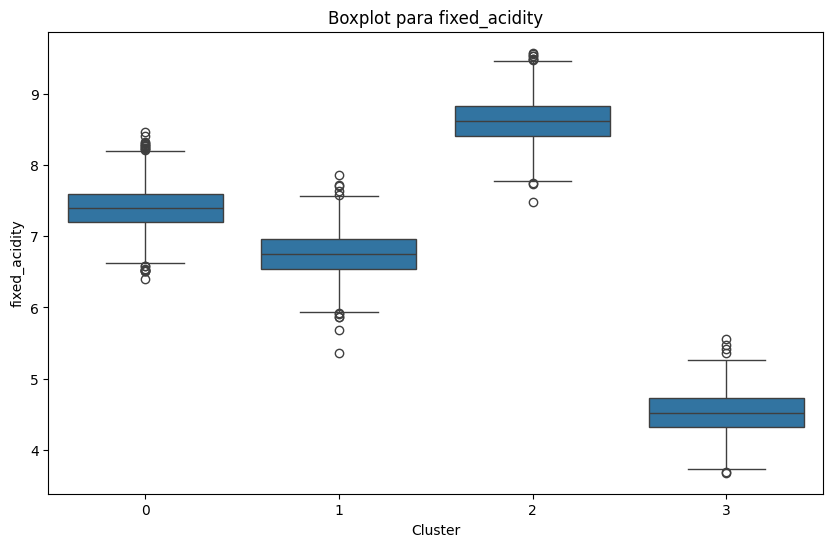

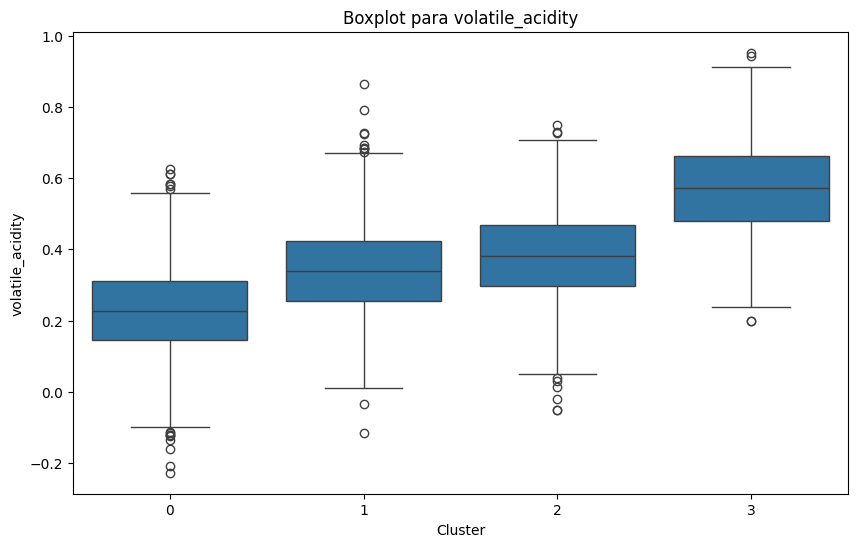

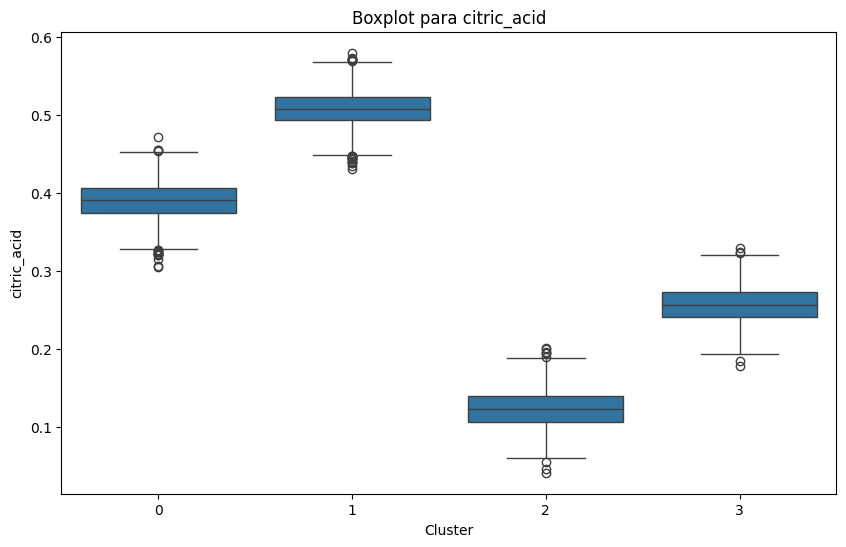

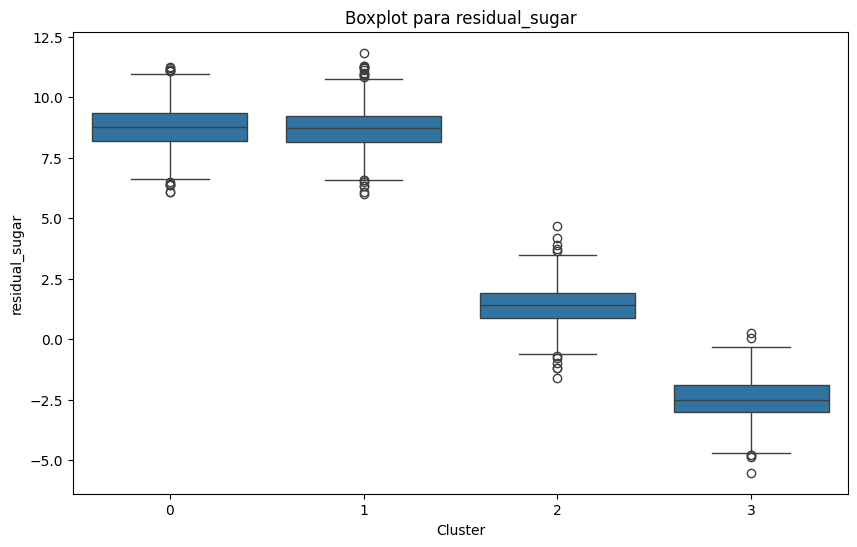

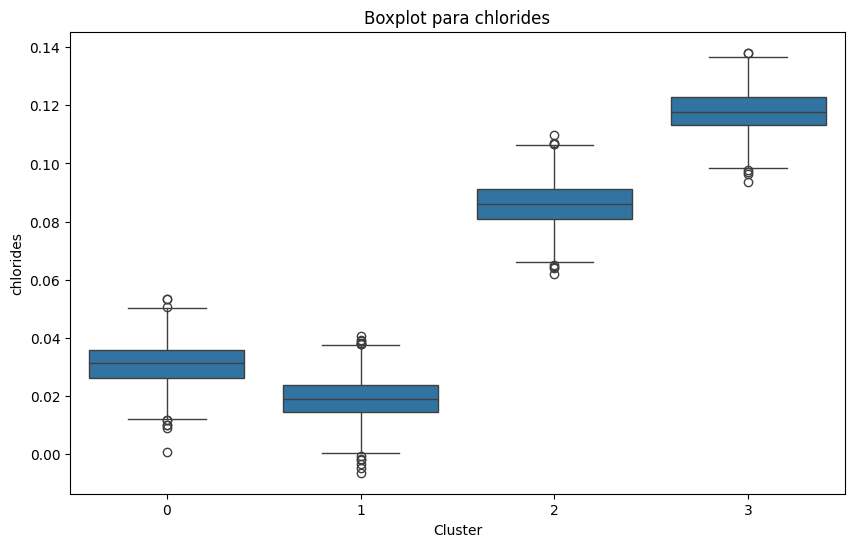

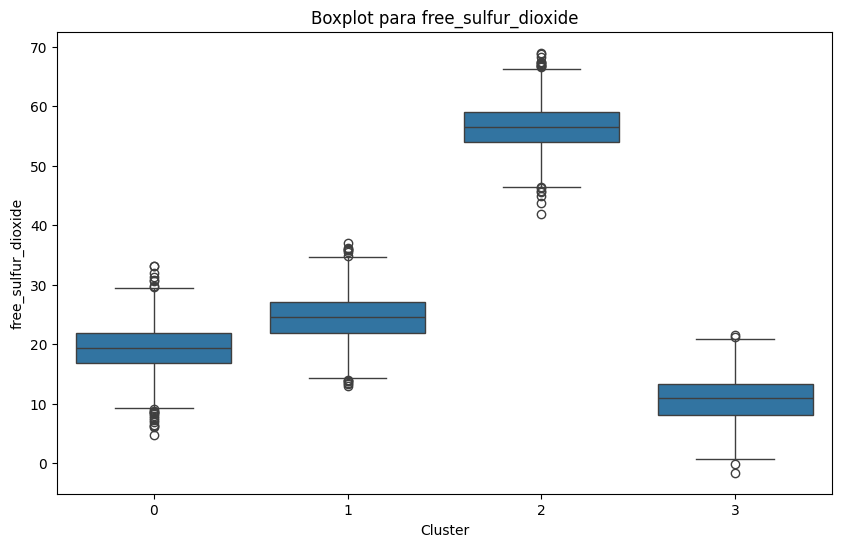

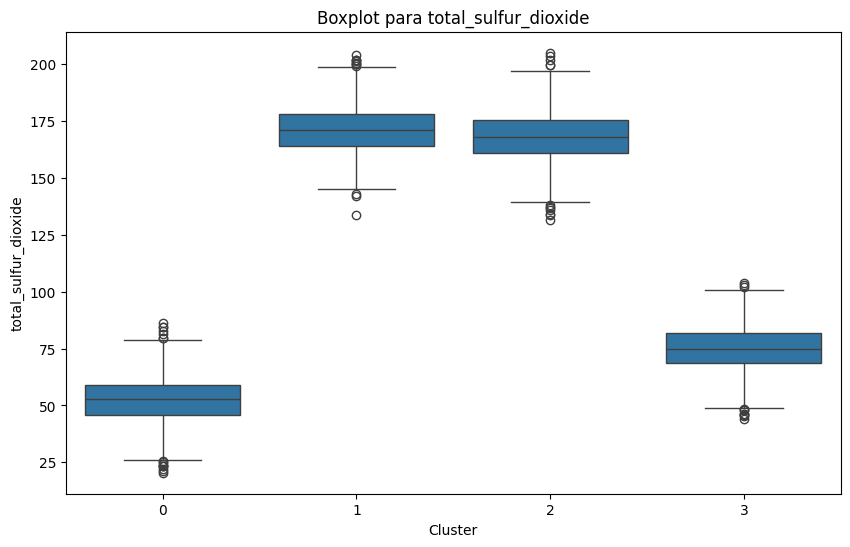

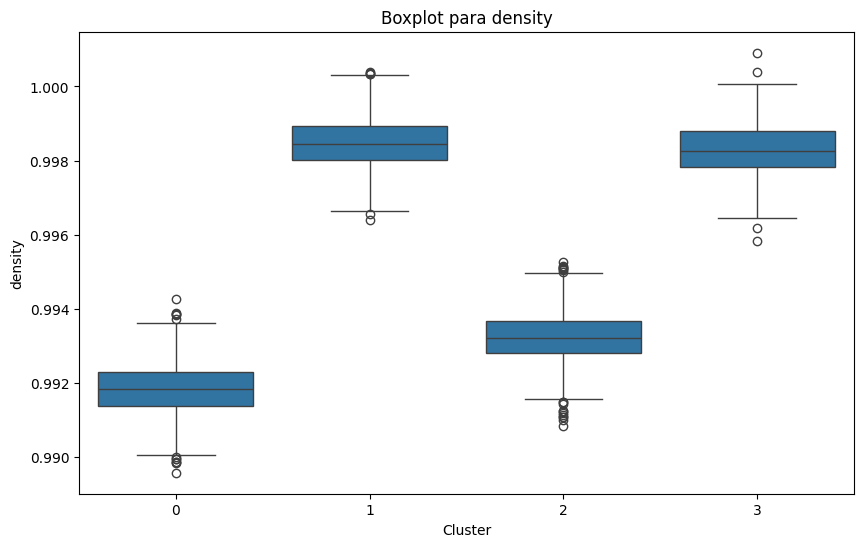

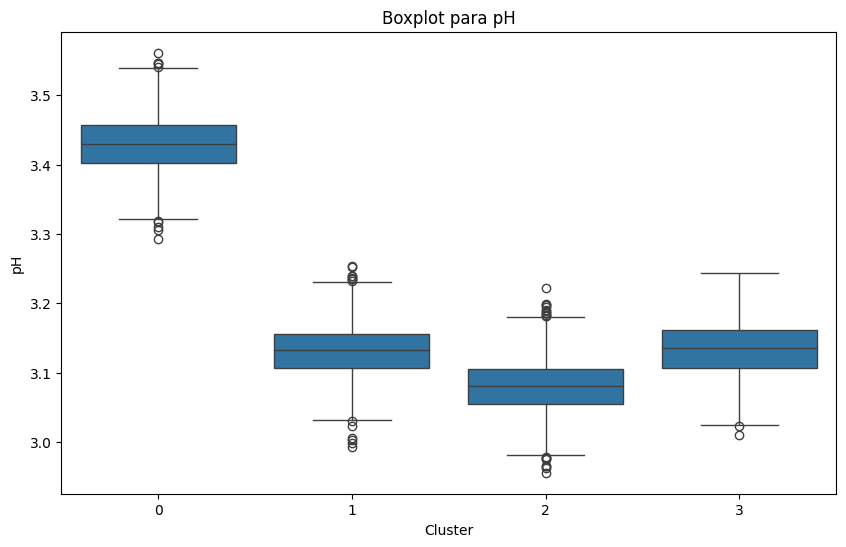

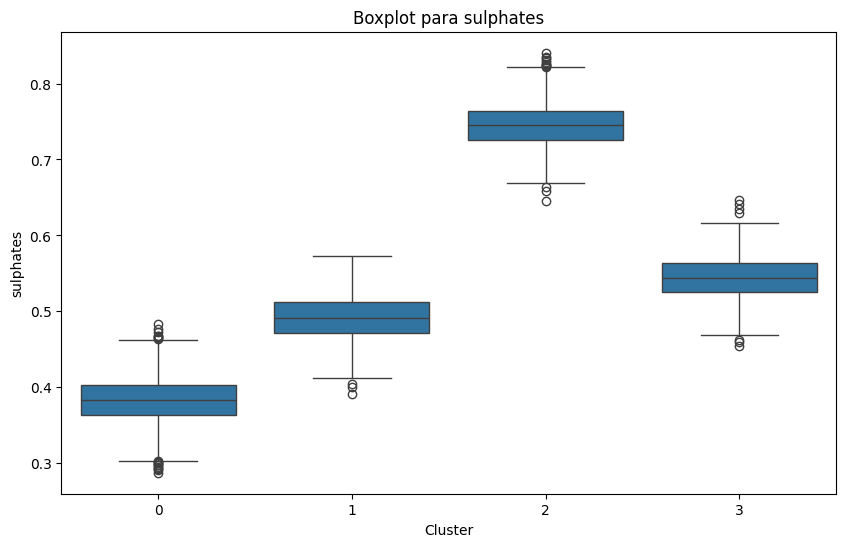

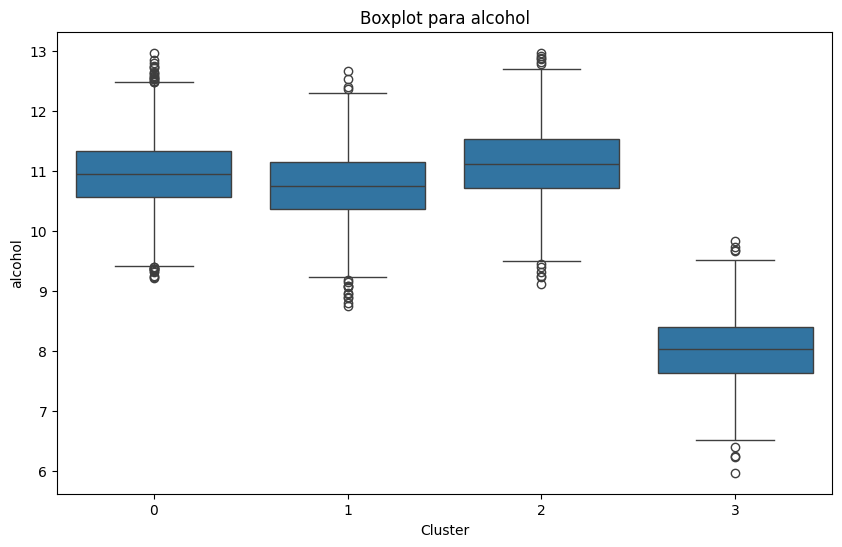

In [15]:
# Obtenemos las variables, ignorando la columna Cluster
columns = data_original.columns.drop(['Cluster'])
# Creamos un diagrama por cada variable
for column in columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=data_original)
    plt.title(f'Boxplot para {column}')
    plt.show()

## Cierre

En este tutorial hemos utilizado la clase `DBSCAN()` para entrenar un modelo de agrupación por densidad. Específicamente, realizamos una búsqueda exhaustiva para seleccionar los hiperparámetros épsilon y el mínimo de puntos en la vecindad utilizando el coeficiente de la silueta como métrica de desempeño para seleccionar el mejor modelo. Finalmente, generamos diagramas de caja con `seaborn` para poder interpretar el resultado de la agrupación.

<font size="3">**Hands-on**  

* Con base en los diagramas de caja ¿Cuáles son las variables que pueden ser utilizadas para caraterizar cada grupo?
    
* El parámetro épsilon de `DBSCAN` es dependiente de la métrica de distancia utilizada. Si en vez de entrenar con la distancia euclidiana utilizamos otra distancia (modificando el parámetro `metric`), ¿cómo cambiaría la definición del espacio de búsqueda?

---
*Creado por: Nicolás Díaz*  
*Revisado por: Haydemar Nuñez*  
*Versión de: Agosto 16, 2023*  
*Universidad de los Andes*   